In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px

from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", tf.test.is_gpu_available())

Num GPUs Available:  True


In [3]:
#Define data path
CAT_DIR = './PetImages/Cat'
DOG_DIR = './PetImages/Dog'

# try:
#     os.makedirs(r'./tmp/cats-v-dogs')
#     os.makedirs(r'./tmp/cats-v-dogs/training')
#     os.makedirs(r'./tmp/cats-v-dogs/validation')
#     os.makedirs(r'./tmp/cats-v-dogs/training/cats')
#     os.makedirs(r'./tmp/cats-v-dogs/training/dogs')
#     os.makedirs(r'./tmp/cats-v-dogs/validation/cats')
#     os.makedirs(r'./tmp/cats-v-dogs/validation/dogs')
# except OSError:
#     print('Error failed to make directory')

In [4]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('PetImages/Dog'))
n_cats = len(os.listdir('PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

In [5]:
def split_data(main_dir, training_dir, validation_dir, split_size):
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)):
            files.append(file)

    shuffled_files = random.sample(files,  len(files))
    split = int(split_size * len(shuffled_files))

    train = shuffled_files[:split]
    validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))

In [6]:


# split_data(CAT_DIR, 'tmp/cats-v-dogs/training/cats','tmp/cats-v-dogs/validation/cats', 0.9)
# split_data(DOG_DIR, 'tmp/cats-v-dogs/training/dogs', 'tmp/cats-v-dogs/validation/dogs', 0.9)


In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory('tmp/cats-v-dogs/training',
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     


validation_generator =  valid_datagen.flow_from_directory( 'tmp/cats-v-dogs/validation',
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 24752 images belonging to 2 classes.
Found 4753 images belonging to 2 classes.


In [8]:
def plot_data(generator, n_images):
    i = 1
    images, labels = generator.next()
    labels = labels.astype('int32')

    plt.figure(figsize=(14, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('on')
        i += 1
        if i == n_images:
            break
    
    plt.show()

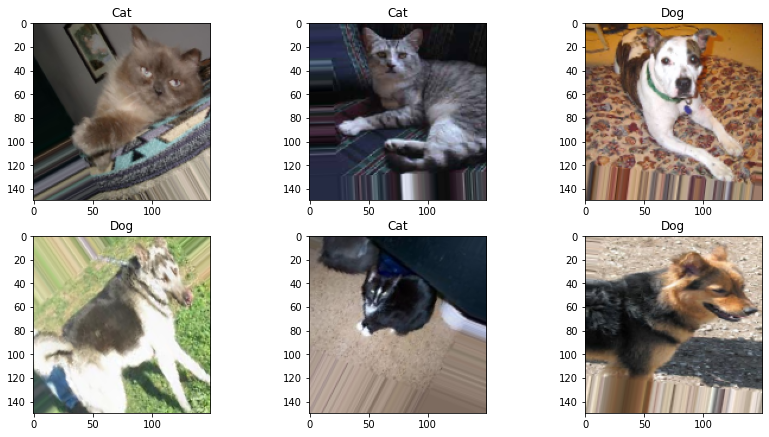

In [9]:
plot_data(train_generator, 7)

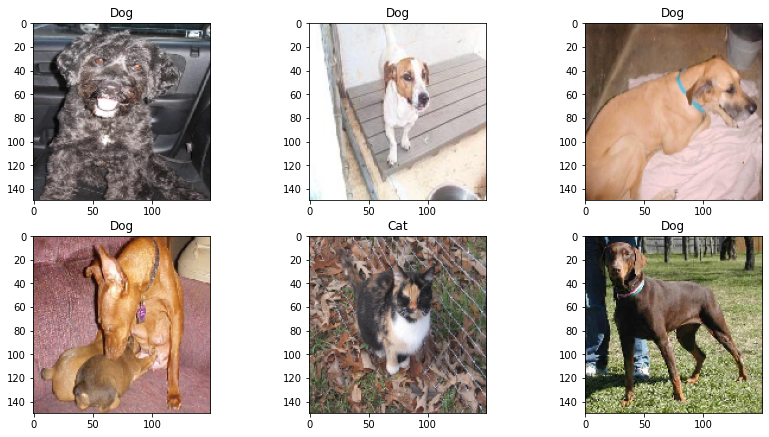

In [10]:

plot_data(validation_generator, 7)

In [11]:
#Load Model
inception = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in inception.layers[:-10]:
    layer.trainable = False # Freeze weights of all layers till except the last 10
    
last_layer = inception.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

layer_output = last_layer.output

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
last layer output shape:  (None, 7, 7, 768)


In [12]:
x = Flatten()(layer_output)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inception.input, predictions)

# model.summary()

In [13]:
def scheduler(epoch, lr):
    
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.2)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # set the callback to our scheduler function

In [14]:
# Set the training parameters
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [15]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5, callbacks=[callback])

Epoch 1/5
237/387 [=================>............] - ETA: 1:18 - loss: 0.5472 - acc: 0.8427

c:\Users\merda\Anaconda3\envs\directml\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning:

Truncated File Read



387/387 [==============================] - 214s 553ms/step - loss: 0.5169 - acc: 0.8541 - val_loss: 0.6052 - val_acc: 0.9550
Epoch 2/5
387/387 [==============================] - 187s 483ms/step - loss: 0.4329 - acc: 0.8813 - val_loss: 2.6441 - val_acc: 0.8889
Epoch 3/5
387/387 [==============================] - 188s 485ms/step - loss: 0.3762 - acc: 0.8899 - val_loss: 1.8347 - val_acc: 0.9173
Epoch 4/5
387/387 [==============================] - 182s 469ms/step - loss: 0.3339 - acc: 0.8999 - val_loss: 1.8962 - val_acc: 0.9234
Epoch 5/5
387/387 [==============================] - 178s 459ms/step - loss: 0.3079 - acc: 0.9021 - val_loss: 4.7463 - val_acc: 0.8462


In [16]:
def plot_prediction(generator, n_images):
    """
    Test the model on random predictions
    Args:
    generator: a generator instance
    n_images : number of images to plot

    """
    i = 1
    # Get the images and the labels from the generator
    images, labels = generator.next()
    # Gets the model predictions
    preds = model.predict(images)
    # print(preds)
    predictions = np.argmax(preds, axis=1)
    # print(predictions)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(f"{class_names[label]}")
            plt.setp(title_obj, color='g') 
            plt.axis('on')
        else:
            title_obj = plt.title(f"{class_names[label]}")
            plt.setp(title_obj, color='r') 
            plt.axis('on')
        
        # print(f"[INFO] {class_names[label]}: {preds[i][0]:.2f}")
        i += 1
        if i == n_images:
            break
       
    
    plt.show()

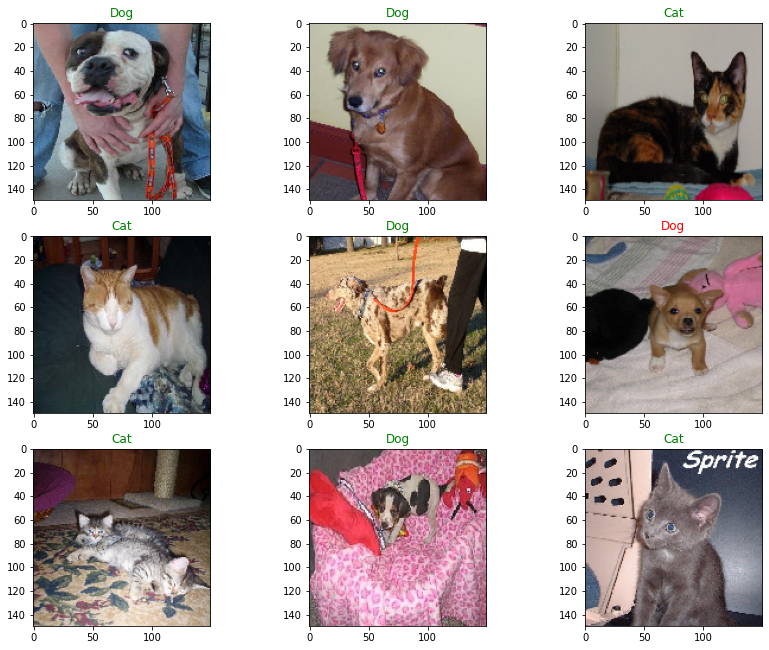

In [17]:
plot_prediction(validation_generator, 10)

In [18]:
results = pd.DataFrame(history.history)
results.tail()

,loss,acc,val_loss,val_acc,lr
0,0.517093,0.854072,0.605151,0.954976,0.0001
1,0.433028,0.881303,2.644082,0.888912,0.0001
2,0.376393,0.889908,1.834708,0.917315,0.0001
3,0.333673,0.899887,1.896169,0.923417,0.0001
4,0.307956,0.902069,4.746298,0.846202,0.0001


In [21]:
fig = px.line(results,y=[results['acc'],results['val_acc']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

1/1 [==============================] - 0s 49ms/step


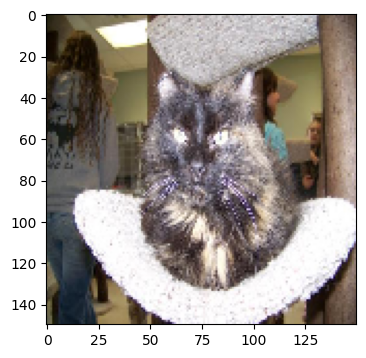

Predicted Class (0 - Dog , 1- Cat):  0.9985134


In [ ]:
image = load_img('./tmp/cats-v-dogs/validation/cats/11180.jpg', target_size=(150, 150))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,150,150,3)
label = model.predict(img)
plt.figure(figsize=(4, 5))
plt.imshow(image)
plt.show()
print("Predicted Class (0 - Dog , 1- Cat): ", label[0][0])